# Molecule rules

Install PyNeuraLogic from PyPI

In [ ]:
! pip install neuralogic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 39.1 MB/s eta 0:00:00
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11261 sha256=68525ec17eb92459e1f5e3598d76978fd32238393414e621fee07ff9c9235083
  Stored in directory: /root/.cache/pip/wheels/c0/74/6f/c63bb0075c49f05e692807fe383ddf2b17a52f567d637af096
Successfully built halo


In [ ]:
from neuralogic.utils.data import Mutagenesis

_, dataset = Mutagenesis()

In [ ]:
from neuralogic.core import Template, R, V

template = Template()


Defining molecules

In [ ]:
from neuralogic.dataset import Dataset
train_dataset = Dataset()
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), # water
        R.bond(1, 2, 10), R.bond(1, 3, 11),
        R.b_1(10), R.b_1(11)
    ],
)
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), R.h(4), R.h(5), R.c(6), # methanol
        R.bond(1, 2, 10), R.bond(6, 3, 11), R.bond(6, 4, 12), R.bond(6, 5, 13),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13), R.saturated(6)
    ],
)

GNN-like graph propagation rule

In [ ]:
template +=  R.layer_1(V.X) <= (R.bond(V.X, V.Y, V.B))

# Functional groups

Bonding rules

In [ ]:
template += R.single_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B))
template += R.single_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_1(V.B))

template += R.double_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B))
template += R.double_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_2(V.B))

template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_3(V.B))
template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B))


# aromatic, ionic, ...
template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_4(V.B))
template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_4(V.B)) # or which nuber




Saturation rule

In [ ]:
from neuralogic.core import Aggregation

template += R.saturated(V.X) <= (R.c(V.X),
                                 R.single_bonded(V.X, V.Y1),
                                 R.single_bonded(V.X, V.Y2),
                                 R.single_bonded(V.X, V.Y3),
                                 R.single_bonded(V.X, V.Y4),
                                 R.special.allldiff(V.Y1, V.Y2, V.Y3, V.Y4))
template += (R.saturated <= (R.saturated(V.C), R.c(V.C))) | [Aggregation.MIN]

Alkane rule

In [ ]:
# molecule is an alkane if all carbon atoms are saturated & it only contains C & H
template += R.not_hydrocarbyl(V.Mol) <= (R.contains(V.Mol, V.X), ~R.c(V.X), ~R.h(V.X)) # check negation

template += R.not_alkane(V.Mol) <= (R.contains(V.Mol, V.C), ~R.saturated(V.C))
template += R.not_alkane(V.Mol) <= (~R.not_hydrocarbyl(V.Mol))
template += R.alkane(V.Mol) <= (~R.not_alkane(V.Mol))

Alkene rule

In [ ]:
template += R.alkene(V.Mol) <= (~R.not_hydrocarbyl(V.Mol), 
                                R.contains(V.Mol, V.C1), R.contains(V.Mol, V.C2),
                                R.c(V.C1), R.c(V.C2),
                                R.double_bonded(V.C1, V.C2) # if there exists a double bond between carbons
                                )


Alkyne rule

In [ ]:
template += R.alkyne(V.Mol) <= (~R.not_hydrocarbyl(V.Mol), 
                                R.contains(V.Mol, V.C1), R.contains(V.Mol, V.C2),
                                R.c(V.C1), R.c(V.C2),
                                R.triple_bonded(V.C1, V.C2) # if there exists a triple bond between carbons
                                )

Haloalkane rule

In [ ]:
# all carbons saturated & there exists a F, Cl, Br or I atom
template += R.haloalkane(V.Mol) <= R.fluoroalkane(V.Mol)
template += R.haloalkane(V.Mol) <= R.chloroalkane(V.Mol)
template += R.haloalkane(V.Mol) <= R.bromoalkane(V.Mol)
template += R.haloalkane(V.Mol) <= R.iodoalkane(V.Mol)

In [ ]:
template += R.fluoroalkane(V.Mol) <= (R.saturated(V.Mol), 
                                      R.contains(V.Mol, V.F), R.f(V.F), 
                                      R.contains(V.Mol, V.C), R.single_bonded(V.C, V.F))

template += R.chloroalkane(V.Mol) <= (R.saturated(V.Mol), 
                                      R.contains(V.Mol, V.Cl), R.cl(V.Cl), 
                                      R.contains(V.Mol, V.C), R.single_bonded(V.C, V.Cl))

template += R.bromoalkane(V.Mol) <= (R.saturated(V.Mol), 
                                     R.contains(V.Mol, V.Br), R.br(V.Br), 
                                     R.contains(V.Mol, V.C), R.single_bonded(V.C, V.Br))

template += R.iodoalkane(V.Mol) <= (R.saturated(V.Mol), 
                                    R.contains(V.Mol, V.I), R.i(V.I), 
                                    R.contains(V.Mol, V.C), R.single_bonded(V.C, V.I))

Phenyl rule (benzene ring)

In [ ]:
template += R.benzene_ring(V.A, V.B, V.C, V.D, V.E, V.F) <= (R.aromatic_bonded(V.A, V.B), 
                                                             R.aromatic_bonded(V.B, V.C),
                                                             R.aromatic_bonded(V.C, V.D),
                                                             R.aromatic_bonded(V.D, V.E),
                                                             R.aromatic_bonded(V.E, V.F),
                                                             R.aromatic_bonded(V.F, V.A))

Alcohol rule

In [ ]:
'''template += R.alcohol(V.Mol) <= (R.contains(V.Mol, V.C), R.alcoholic(V.C))
template += R.alcoholic(V.C) <= (R.saturated(V.C), R.o(V.O), R.h(V.H), 
                                 R.single_bonded(V.C, V.O),
                                 R.single_bonded(V.O, V.H))'''

template += R.alcoholic <= (R.saturated, R.o(V.O), R.h(V.H), 
                                 R.single_bonded(V.C, V.O),
                                 R.single_bonded(V.O, V.H))

Carbonyl groups rules

In [ ]:
# carbonyl group contains a carbon double bonded with oxygen
template += R.carbonyl(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.O), R.carbonyl_group(V.O, V.C))
template += R.carbonyl_group(V.C, V.O) <= (R.c(V.C), R.o(V.O), R.double_bonded(V.O, V.C))
template += R.carbonyl_group(V.C, V.O, V.R1, V.R2) <= (R.c(V.C), R.o(V.O), R.double_bonded(V.O, V.C), R.single_bonded(V.C, V.R1), R.single_bonded(V.C, V.R2))

In [ ]:
# ketone
template += R.ketone(V.Mol) <= (R.contains(V.Mol, V.C), 
                                R.carbonyl_group(V.C, _, V.R1, V.R2),
                                R.c(V.R1), R.c(V.R2))

# aldehyde
template += R.aldehyde(V.Mol) <= (R.contains(V.Mol, V.C), 
                                  R.carbonyl_group(V.C, _, V.R, V.H),
                                  R.c(V.R), R.h(V.H))

# acylhalide
template += R.acyl_fluoride(V.Mol) <= (R.contains(V.Mol, V.C), 
                                       R.carbonyl_group(V.C, _, V.R, V.X),
                                       R.c(V.R), R.f(V.X))

template += R.acyl_chloride(V.Mol) <= (R.contains(V.Mol, V.C), 
                                       R.carbonyl_group(V.C, _, V.R, V.X),
                                       R.c(V.R), R.cl(V.X))

template += R.acyl_bromide(V.Mol) <= (R.contains(V.Mol, V.C), 
                                      R.carbonyl_group(V.C, _, V.R, V.X),
                                      R.c(V.R), R.br(V.X))

template += R.acyl_iodide(V.Mol) <= (R.contains(V.Mol, V.C), 
                                     R.carbonyl_group(V.C, _, V.R, V.X),
                                     R.c(V.R), R.i(V.X))


template += R.acyl_halide(V.Mol) <= R.acyl_fluoride(V.Mol)
template += R.acyl_halide(V.Mol) <= R.acyl_chloride(V.Mol)
template += R.acyl_halide(V.Mol) <= R.acyl_bromide(V.Mol)
template += R.acyl_halide(V.Mol) <= R.acyl_iodide(V.Mol)

Carboxylic acids

In [ ]:
# carboxylic acid
template += R.carboxylic_acid(V.Mol) <= (R.contains(V.Mol, V.C), R.carbonyl_group(V.C, _, V.R, V.O),
                                R.c(V.R), R.o(V.O),
                                R.h(V.H), R.single_bonded(V.O, V.H))

Esters

In [ ]:
template += R.ester(V.Mol) <= (R.contains(V.Mol, V.C), R.carbonyl_group(V.C, _, V.R, V.O),
                                R.c(V.R), R.o(V.O),
                                R.h(V.H), R.single_bonded(V.O, V.H))

template += R.carbonate_ester(V.Mol) <= (R.contains(V.Mol, V.C), R.carbonyl_group(V.C, _, V.O1, V.O2),
                                R.o(V.O1), R.o(V.O2),
                                
                                R.c(V.R1), R.single_bonded(V.R1, V.O1),
                                R.c(V.R2), R.single_bonded(V.O2, V.R2))

Peroxydes

In [ ]:
# peroxyde
template += R.peroxyde(V.Mol) <= (R.contains(V.Mol, V.C), R.c(V.C), # or saturated?
                                  R.o(V.O1), R.o(V.O2), R.c(V.R), 
                                  R.single_bonded(V.C, V.O1),
                                  R.single_bonded(V.O1, V.O2),
                                  R.single_bonded(V.O2, V.R))

# hydroperoxyde
template += R.hydroperoxyde(V.Mol) <= (R.contains(V.Mol, V.C), R.c(V.C), # or saturated?
                                       R.o(V.O1), R.o(V.O2), R.h(V.H), 
                                       R.single_bonded(V.C, V.O1),
                                       R.single_bonded(V.O1, V.O2),
                                       R.single_bonded(V.O2, V.H))

Ethers

In [ ]:
template += R.ether(V.Mol) <= (R.contains(V.Mol, V.C), R.c(V.C), 
                                R.o(V.O), R.c(V.R), 
                                R.single_bonded(V.C, V.O),
                                R.single_bonded(V.O, V.R))



In [ ]:
# dicarbonyls, acetals, hemiacetals/ketals, orthoesters, orthocarbonate esters, carboxylic acit anhydrides
# nitrogen, sulphur, phosphorus, boron, metals, polymers, heterocycles!, biomolecules

# Characteristic reactions

No available datasets for this purpose

In [ ]:
#template += R.produces(Reaction, [V.Reactants], [V.Products]) <= (R.reacts(R.Reaction, React) for React in V.Reactants,
#                                                                    R.Reaction([V.Reactants], [V.Products]))

In [ ]:
# alkanes
# combustion reaction
template += R.reacts(combustion, V.Mol) <= (R.alkane(V.Mol))
template += R.reacts(combustion, V.Mol, V.State) <= (R.alkane(V.Mol), R.favorable_state(R.combustion, V.State))

# make some template for this?? How to add quantities of reactants/products
#template += R.combustion([V.Alkane[n], V.Oxygen[2*n]], [V.Water, V.CX]) <= () # if enough oxygen produce water and CO2, otherwise produce CO or C if even less

# Electronegativity rules

Lacking 3d structure to be able to determine the vectors

# Prediction

In [ ]:
template += R.predict[1,] <= R.layer_1(V.X)
template += R.predict[1,] <= R.alcoholic #(V.X)

In [ ]:

train_dataset.add_queries([
    R.predict[0],
    R.predict[1],
])
print(template)

layer_1(X) :- bond(X, Y, B).
single_bonded(X, Y) :- bond(X, Y, B), b_1(B).
single_bonded(X, Y) :- bond(Y, X, B), b_1(B).
double_bonded(X, Y) :- bond(X, Y, B), b_2(B).
double_bonded(X, Y) :- bond(Y, X, B), b_2(B).
triple_bonded(X, Y) :- bond(X, Y, B), b_3(B).
triple_bonded(X, Y) :- bond(Y, X, B), b_3(B).
aromatic_bonded(X, Y) :- bond(X, Y, B), b_4(B).
aromatic_bonded(X, Y) :- bond(Y, X, B), b_4(B).
saturated(X) :- c(X), single_bonded(X, Y1), single_bonded(X, Y2), single_bonded(X, Y3), single_bonded(X, Y4), @allldiff(Y1, Y2, Y3, Y4).
saturated :- saturated(C), c(C). [aggregation=min]
alcoholic :- saturated, o(O), h(H), single_bonded(C, O), single_bonded(O, H).
{1} predict :- layer_1(X).
{1} predict :- alcoholic.


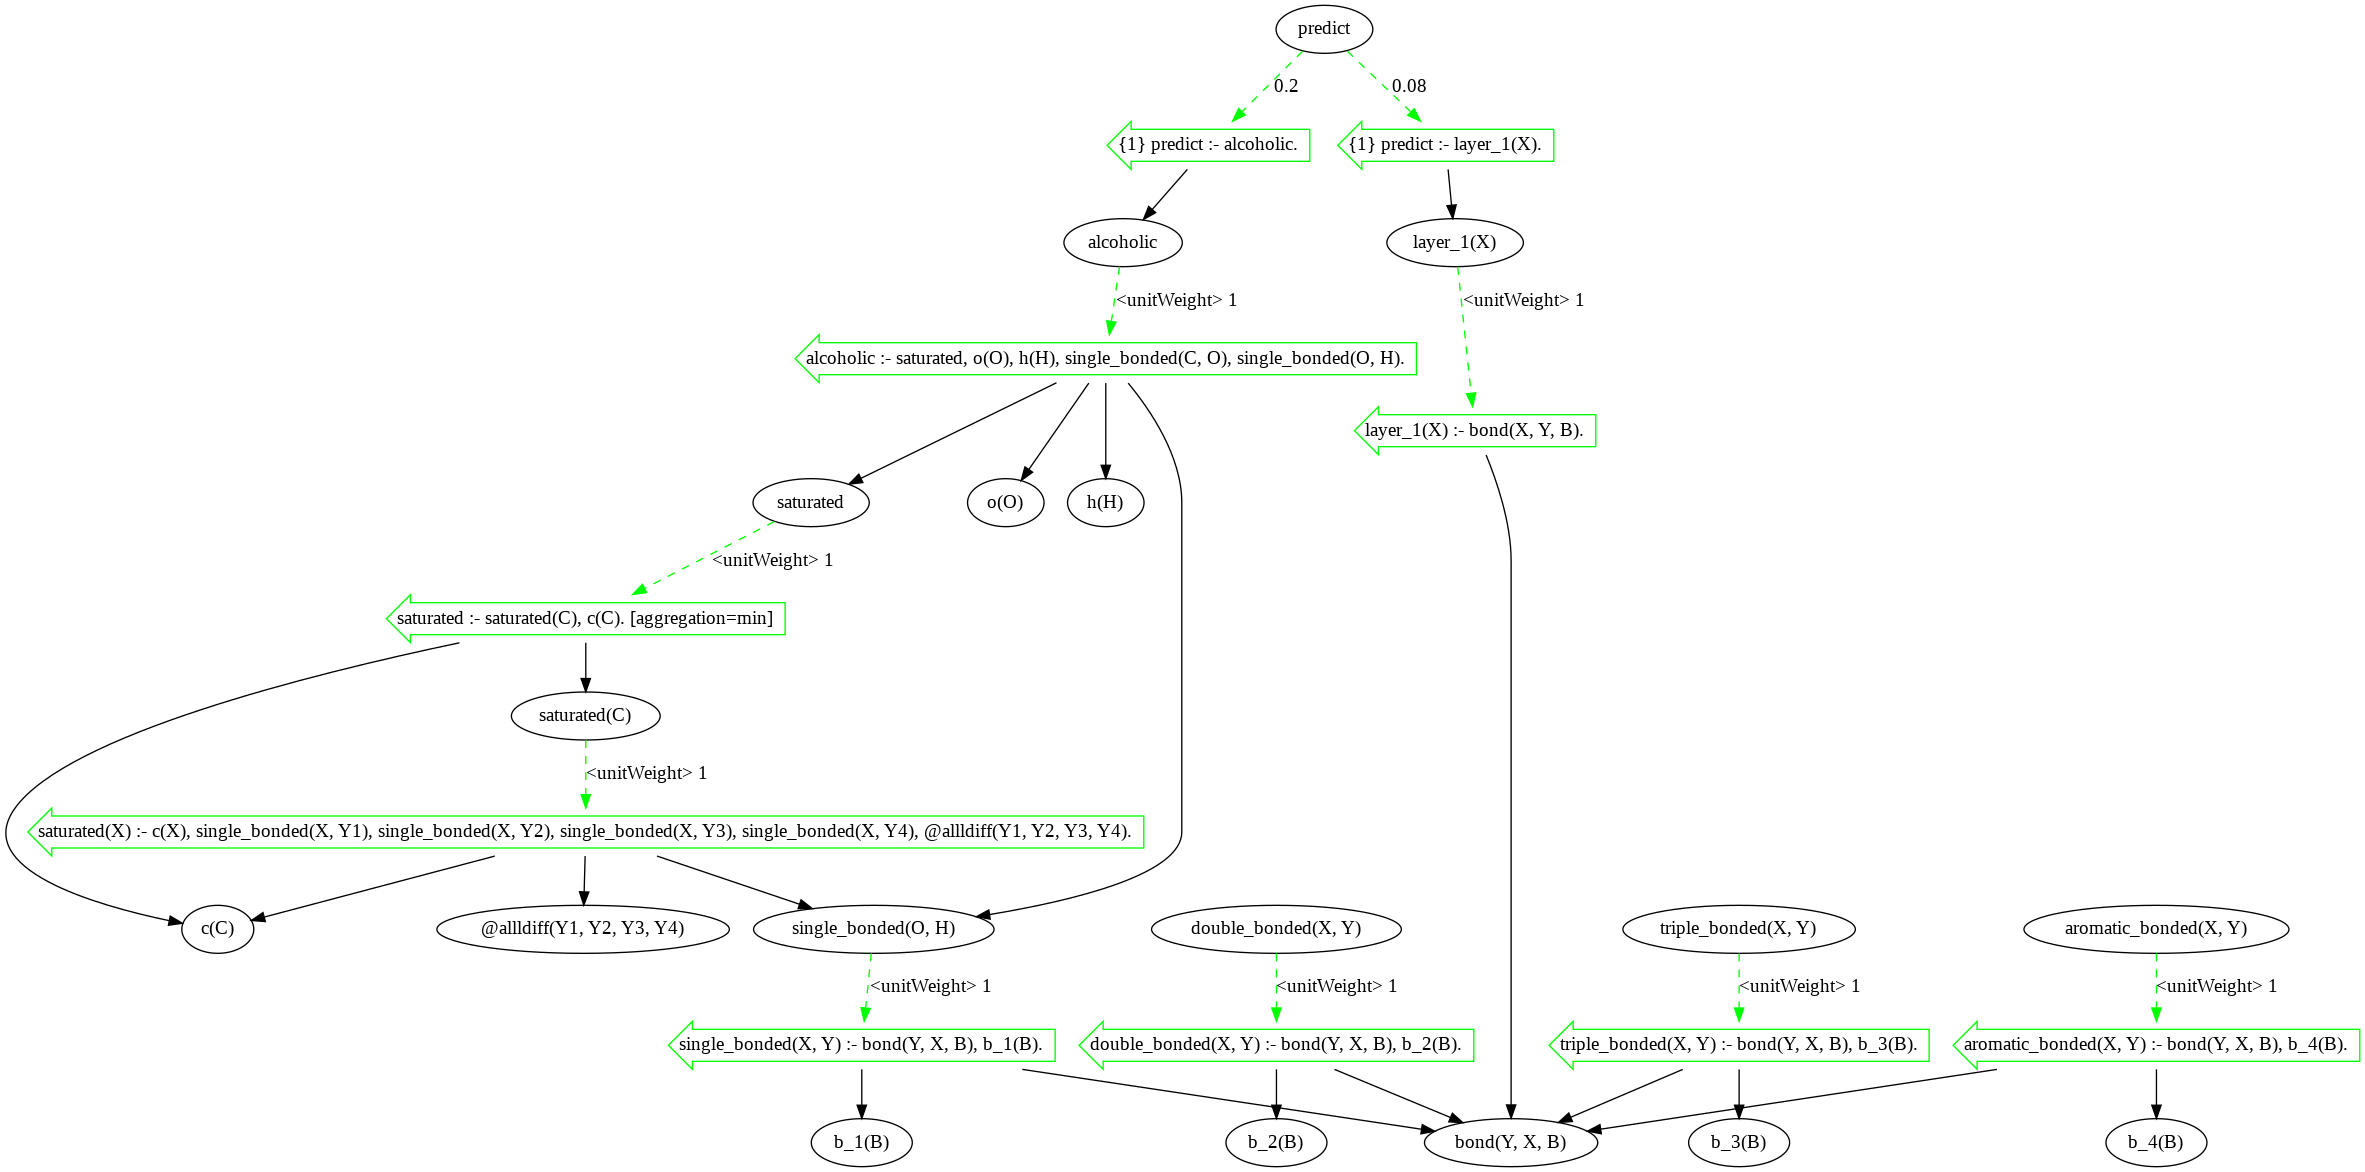

In [ ]:
template.draw()

## Training

When we have our dataset and template ready, it's time to build ("ground") the template over the dataset and start training.
We can do the training manually and write our own custom training loop, but we can also use predefined helpers - *evaluators*,
that handle model and dataset building, training, and more. Evaluators can be customized via `Settings`.

<sup>Note that building the dataset (=grounding the logic rules and translating into neural networks) may take a while, depending on the complexity of your template.
But this is only done once before the training itself, which takes up most of the time anyway.
<sup>

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE, CrossEntropy
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam

settings = Settings(optimizer=Adam(lr=0.001), epochs=100, error_function=MSE())
evaluator = get_evaluator(template, settings)

built_dataset = evaluator.build_dataset(train_dataset)

#evaluator.test(train_dataset)

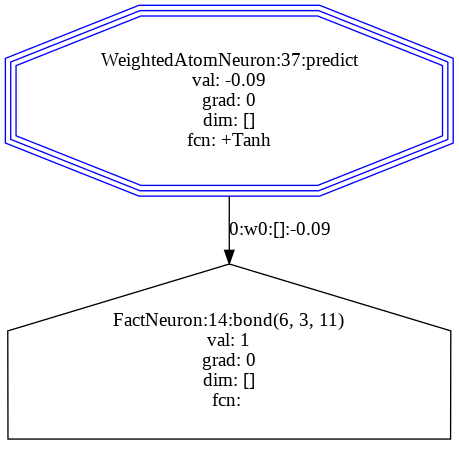

In [ ]:
built_dataset[1].draw()

In [ ]:
evaluator.test(train_dataset, generator=False)

[-0.2480380977303278, -0.2480380977303278]

Finally, we iterate through the iterator encapsulated in the `train` method of the evaluator, which yields a total loss of the epoch and the number of samples of the current epoch.
We then get access to the results from the training loop that we can further visualize, inspect, log, etc.

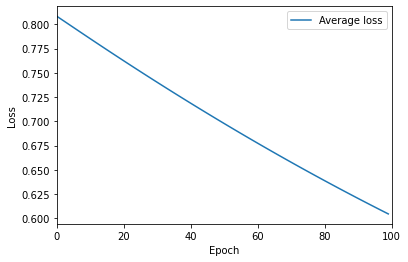

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

average_losses = []

for current_total_loss, number_of_samples in evaluator.train(built_dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, settings.epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

We can then check the trained model predictions (for the same sample set here) by utilizing the `test` method.

In [ ]:
for sample, y_hat in zip(built_dataset.samples, evaluator.test(built_dataset)):
    print(f"Target: {sample.java_sample.target}, Predicted: {round(y_hat)} ({y_hat})")

Target: 0, Predicted: 0 (-0.0946318975358623)
Target: 1, Predicted: 0 (-0.0946318975358623)
